# Non-linear optimization

In this third of the session, we are going to discuss how to go about solving non-linear optimization problems of the form:
\begin{align}
\min \ f(x)\\
\text{s.t.} \ g(x)=0,\\
\ \ h(x) \leq 0.
\end{align}
where $f(x)$ is a conic function (e.g., linear, quadratic, socp, sdp, exponential), $g(x)$ is an affine function (i.e. linear) and $h(x)$ is a conic function. 

Good resources on non-linear optimization are the books by Boyd and Vandenberghe, Bertsekas, and Ben-Tal and Nemirovski.

# SVM's
Support Vector Machines are a popular model in machine learning for classification. 

We'll use support vector machines as a running example throughout this notebook, to keep things concrete and illustrate the basic use of JuMP.jl for solving nonlinear optimization problems.

Specifically, we are going to build our own custom svm solver, so that we can include constraints which off-the-shelf SVM solvers can't handle. Because we are using JuMP, we should expect that our solver will be slower but more flexible than state-of-the-art SVM solvers such as scikit-learn.

The basic problem is that we are given a set of N points $x_1,x_2,\ldots, x_N \in \mathbb{R}^n$ and labels $y_1, y_2, \ldots, y_n \in \{-1,+1\}$. And we want to find a hyperplane of the form $w^Tx-b = 0$ that separates the two classes, i.e. $w^Tx_i - b \geq 1$ when $y_i = +1$ and $w^Tx_i - b \leq -1$ when $y_i = -1$. This condition can be written as $y_i(w^Tx_i - b) \geq 1, \forall\, i$.

Such a hyperplane will not exist in general if the data overlap, so instead we'll just try to minimize violations of the constraint $y_i(w^Tx_i - b) \geq 1, \forall\, i$ by adding a penalty when it is violated. The optimization problem can be stated as $$
\min_{w,b} \sum_{i=1}^N \left[\max\{0, 1 - y_i(w^Tx_i - b)\}\right] + \gamma ||w||_2^2
$$ Note that we penalize the norm of $w$ in order to guarantee a unique solution.

Now, let's write our own SVM solver!

In [61]:
#Pkg.add("PyPlot", "Distributions", "LinearAlgebra", "PyPlot")
using Gurobi #, Pick your favourite solver here e.g. CPLEX/Gurobi/Mosek. Note that you need to install these solvers to use them
using Distributions
using PyPlot
using LinearAlgebra
using JuMP
using Mosek

In [62]:
# Function to generate some random test data
function gen_data(N)
    # for +1 data, symmetric multivariate normal with center at (1,2)
    pos = rand(MvNormal([1.0,2.0],1.0),N)
    # for -1 data, symmetric multivariate normal with center at (-1,1)
    neg = rand(MvNormal([-1.0,1.0],1.0),N)
    x = [pos neg]
    y = [fill(+1,N);fill(-1,N)]
    return x,y
end

gen_data (generic function with 1 method)

Let's see what the data look like.

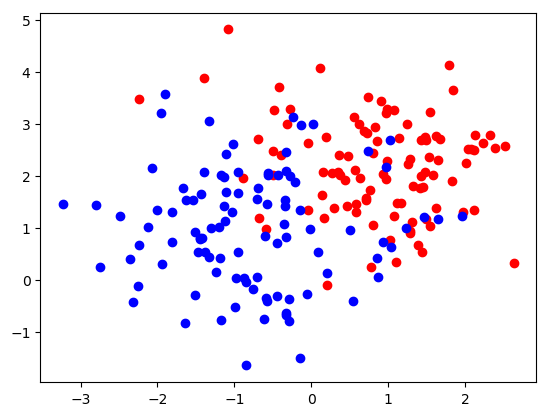

In [63]:
x,y = gen_data(100)
plot(x[1,1:100], x[2,1:100], "ro", x[1,101:200], x[2,101:200], "bo");

Now we translate the optimization problem into JuMP form.

**Exercise: fill in the blanks to write the SVM solver.**

In [64]:
using JuMP
const γ = 0.005
function svm(x,y)
    n = size(x,1) # problem dimension
    N = size(x,2) # number of points
    
    svmModel=Model(solver=GurobiSolver()) #Change to the solver you are using
    @variable(svmModel, w[1:n])
    @variable(svmModel, b)
    @variable(svmModel, z[1:N]>=0)

    #########################################################
    @constraint(svmModel,z.>=ones(N)-y.*(x'*w-b))
    @objective(svmModel, Min, γ*w'*w+sum(z))
    #########################################################
    
    status=solve(svmModel)
    return getvalue(w), getvalue(b)
end

svm (generic function with 1 method)

In [65]:
N = 500
x,y = gen_data(N)

w,b = svm(x,y)

Academic license - for non-commercial use only
Optimize a model with 1000 rows, 1003 columns and 4000 nonzeros
Model has 2 quadratic objective terms
Coefficient statistics:
  Matrix range     [8e-05, 5e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-02, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1000 rows, 1003 columns, 4000 nonzeros
Presolved model has 2 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 Free vars  : 3
 AA' NZ     : 3.000e+03
 Factor NZ  : 4.006e+03 (roughly 1 MByte of memory)
 Factor Ops : 1.601e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.17594999e+07 -7.37771857e-11  0.00e+00 9.71e-06  1.01e+06     0s
   1   2.09811028e+07 -6.69252540e+02  0.00e+00 2.56e+01  3.64e+04     0s
   2   1.35224578e+07 -2.35048933e+05 

([1.39461, 0.718728], 1.1516963494101184)

And the solution?

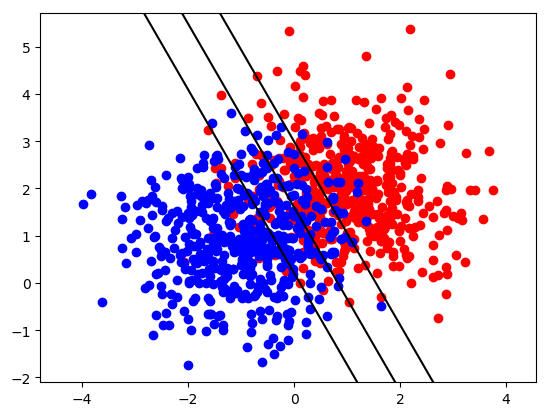

In [66]:
plot(x[1,1:N], x[2,1:N], "ro", x[1,(N+1):2N], x[2,(N+1):2N], "bo");

xmin, xmax = xlim()
ymin, ymax = ylim()
y1 = (1+b-w[1]*xmin)/w[2]
y2 = (1+b-w[1]*xmax)/w[2]
plot([xmin,xmax], [y1,y2], "k-");
y1 = (-1+b-w[1]*xmin)/w[2]
y2 = (-1+b-w[1]*xmax)/w[2]
plot([xmin,xmax], [y1,y2], "k-");
y1 = (b-w[1]*xmin)/w[2]
y2 = (b-w[1]*xmax)/w[2]
ylim(ymin,ymax)
plot([xmin,xmax], [y1,y2], "k-");

# Exercise: The standard support vector classifier

A variant on the support vector classification problem is the *standard* support vector classification problem, which can be stated as follows:
$$
\min_{w,b} \sum_{i=1}^N \left[\max\{0, 1 - y_i(w^Tx_i - b)\}\right] + \gamma ||w||_2,
$$
subject to the same constraints as our previous problem (i.e., $l_2$ rather than $l_2^2$ regularization). 

We will not discuss the mathematics of this problem; if you are interested, see section $8.6$ of Boyd+Vandenberghe. 

Exercise: fill in the blanks in the below function, to write a standard support vector machine solver.

Hint: if we have a vector $x$, we can model norm(x) with an auxillary variable $t$ and the constraint:

@constraint(svmModel, soc, norm(w[i] for i=1:n)<=t)

(The "soc" indicates that we are using a second order cone constraint).

In [74]:
using JuMP
const γ = 0.005
function svm2(x,y)
    n = size(x,1) # problem dimension
    N = size(x,2) # number of points
    
    svmModel=Model(solver=GurobiSolver()) #Change to the solver you are using
    @variable(svmModel, w[1:n])
    @variable(svmModel, b)
    @variable(svmModel, z[1:N]>=0)
    @variable(svmModel, t>=0)
    @constraint(svmModel, soc, norm(w[i] for i=1:n)<=t)

    #########################################################
    @constraint(svmModel,z.>=ones(N)-y.*(x'*w-b))
    @objective(svmModel, Min, γ*t+sum(z))
    #########################################################
    
    status=solve(svmModel)
    return getvalue(w), getvalue(b)
end

svm2 (generic function with 1 method)

In [75]:
w2,b2 = svm2(x,y)

Academic license - for non-commercial use only
Optimize a model with 1003 rows, 1007 columns and 4006 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [8e-05, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-03, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 1002 rows, 1006 columns, 4004 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 Free vars  : 3
 AA' NZ     : 3.003e+03
 Factor NZ  : 4.013e+03 (roughly 1 MByte of memory)
 Factor Ops : 1.604e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.12339330e+03  4.99875434e+02  1.08e-19 5.00e+02  1.96e+00     0s
   1   7.32350530e+02  4.11084469e+02  4.76e-07 3.29e+02  5.70e-01     0s
  

([1.39428, 0.718908], 1.1515540779381894)

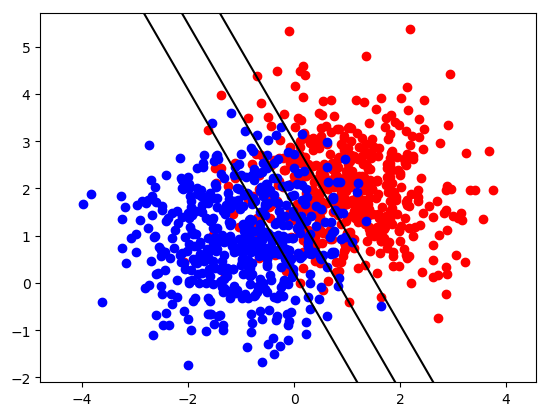

In [71]:
plot(x[1,1:N], x[2,1:N], "ro", x[1,(N+1):2N], x[2,(N+1):2N], "bo");

xmin, xmax = xlim()
ymin, ymax = ylim()
y1 = (1+b2-w2[1]*xmin)/w2[2]
y2 = (1+b2-w2[1]*xmax)/w2[2]
plot([xmin,xmax], [y1,y2], "k-");
y1 = (-1+b2-w2[1]*xmin)/w2[2]
y2 = (-1+b2-w2[1]*xmax)/w2[2]
plot([xmin,xmax], [y1,y2], "k-");
y1 = (b2-w2[1]*xmin)/w2[2]
y2 = (b2-w2[1]*xmax)/w2[2]
ylim(ymin,ymax)
plot([xmin,xmax], [y1,y2], "k-");

# Discussion

What's the difference between the support vector machine solution and the standard support vector machine solution?

When will this difference be substantial?

# Exercise: Sensitivity analysis

Increase the distance between the centers of the blue and red data points by modifying the gen_data function. 

How does the solution change? 

How does the solve time change?

# Exercise: how would you cross-validate $\gamma$?

# A word of caution

Our support vector machines can be solved quite efficiently by Gurobi. However, Gurobi can't solve all non-linear optimization problems. Indeed, (in my personal experience) it becomes less efficient than state-of-the-art nonlinear optimization solvers as the problem complexity increases.

Consequently, if you are trying to solve a complex NLP, or a large-scale NLP, it may be worthwhile installing a state-of-the-art NLP solver such as Mosek (see https://www.mosek.com/, they have academic licenses like Gurobi) and solving the problem via Mosek instead.

# Credit

Some of this material is adapted from the 2016 version of this course, written by Yeesian Ng and Miles Lubin. 